In [ ]:
!pip install numpy==1.26.4

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/proyectoint/'



df = pd.read_parquet(ruta + "ss2kc.parquet")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.shape

(12705, 4)

In [ ]:
# add column to df that is 1 if theres is a 1 in the labels list or 0 if not
df['existeK'] = df['labels'].apply(lambda x: 1 if 1 in x else 0)


In [ ]:
df.head()

,subject_id,signal,init_sec,labels,existeK
0,01-02-0001,"[0.8642647230320131, -1.3254061324679178, -2.0...",1280.76108,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,01-02-0001,"[19.979204735578016, 24.564032163729603, 27.49...",1300.76108,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,01-02-0001,"[-0.6234027275576637, 1.0729096011331865, 2.46...",1320.76108,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,01-02-0001,"[1.52619980314834, 3.8336439275996477, 5.85130...",1340.76108,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,01-02-0001,"[2.417046285089186, 1.2075578435732488, -0.733...",1360.76108,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [ ]:
# cuenta cuantos 1 hay en existe K y cuantos 0
df['existeK'].value_counts()

,count
existeK,
1,6374
0,6331


hay 12705 señales donde 6331 no presentan complejo K y 6374 en las que si hay.

# CNN para solo detectar si existe complejo K en la señal

In [ ]:
class CNNDETECTAR(nn.Module):
    """
    A CRNN (Convolutional Recurrent Neural Network) model based on the provided architecture diagram.
    This model processes a time-series signal to perform classification at each time step
    of the downsampled sequence.
    """
    def __init__(self, in_channels=1, Nf=32, N1=128, N2=128, p1=0.5, p2=0.5): # num_classes removed
        """
        Initializes the model layers.
        """
        super(CNNDETECTAR, self).__init__()

        # --- Convolutional Feature Extractor ---
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=Nf, out_channels=Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=Nf, out_channels=2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=2*Nf, out_channels=2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(in_channels=2*Nf, out_channels=4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=4*Nf, out_channels=4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # --- Dropout Layers ---
        self.dropout1 = nn.Dropout(p=p1)
        self.dropout2 = nn.Dropout(p=p2)

        # --- Recurrent Blocks (Bidirectional LSTMs) ---
        self.blstm1 = nn.LSTM(input_size=4*Nf, hidden_size=N1, num_layers=1, batch_first=True, bidirectional=True)
        self.blstm2 = nn.LSTM(input_size=2*N1, hidden_size=N1, num_layers=1, batch_first=True, bidirectional=True)

        # --- Classifier ---
        # CHANGE 1: The final layer now outputs 1 channel for binary classification.
        self.classifier = nn.Sequential(
            nn.Conv1d(in_channels=2*N1, out_channels=N2, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=N2, out_channels=1, kernel_size=1) # Changed num_classes to 1
        )

    def forward(self, x):
        """
        Defines the forward pass of the network.
        """
        # Pass through convolutional blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Reshape for LSTMs
        x = x.permute(0, 2, 1)

        # Pass through recurrent blocks
        x = self.dropout1(x)
        x, _ = self.blstm1(x)
        x = self.dropout2(x)
        x, _ = self.blstm2(x)
        x = self.dropout2(x)

        # Reshape for 1x1 Convs
        x = x.permute(0, 2, 1)

        # Pass through the classifier
        logits_seq = self.classifier(x) # -> Shape is now (batch_size, 1, 500)

        # CHANGE 2: Add Global Average Pooling to collapse the time dimension.
        # This takes the mean of the 500 time steps to get a single prediction.
        logits = torch.mean(logits_seq, dim=2) # -> Shape becomes (batch_size, 1)

        return logits

In [ ]:
# Configurar el dispositivo (usar GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [ ]:
# df_detectar solo debe tener las columnas signal y existeK
df_detectar = df[['signal', 'existeK']]

In [ ]:
# División de datos: 80% entrenamiento, 10% validación, 10% prueba
# Primero, separamos el conjunto de entrenamiento del resto
train_df, temp_df = train_test_split(
    df_detectar, test_size=0.2, random_state=42, stratify=df_detectar['existeK']
)
# Luego, dividimos el resto en validación y prueba
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['existeK']
)

print(f"\nTamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(val_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")




Tamaño del conjunto de entrenamiento: 10164
Tamaño del conjunto de validación: 1270
Tamaño del conjunto de prueba: 1271


In [ ]:
# --- 3. DATASETS Y DATALOADERS DE PYTORCH ---

class SignalDataset(Dataset):
    """Custom Dataset for loading signals and labels."""
    def __init__(self, dataframe):
        self.signals = torch.tensor(np.array(dataframe['signal'].tolist()), dtype=torch.float32)
        self.labels = torch.tensor(dataframe['existeK'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # CORRECTED COMMENT: Add a "channel" dimension for the CNN (4000) -> (1, 4000)
        signal = self.signals[idx].unsqueeze(0)
        label = self.labels[idx].unsqueeze(0)
        return signal, label

BATCH_SIZE = 64

# Crear instancias de Dataset
train_dataset = SignalDataset(train_df)
val_dataset = SignalDataset(val_df)
test_dataset = SignalDataset(test_df)

# Crear instancias de DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 4. FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN ---

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Función para entrenar el modelo durante una época."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Función para evaluar el modelo en un conjunto de datos."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc





In [ ]:
# --- 5. CICLO PRINCIPAL DE ENTRENAMIENTO (CON EARLY STOPPING) ---

# Hiperparámetros
EPOCHS = 30
LEARNING_RATE = 0.0001

# --- Early Stopping Parameters ---
patience = 10  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize with a very high value

# Instanciar modelo, función de pérdida y optimizador
model = CNNDETECTAR().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Almacenar historial para graficar
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("\n--- Iniciando Entrenamiento ---")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Época {epoch+1}/{EPOCHS} | "
          f"Loss de entrenamiento: {train_loss:.4f} | Acc de entrenamiento: {train_acc:.4f} | "
          f"Loss de validación: {val_loss:.4f} | Acc de validación: {val_acc:.4f}")

    # --- Early Stopping Logic ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Optional: Save the best model here
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\n--- Early stopping en la época {epoch+1} ---")
        break # Exit the training loop

print("--- Entrenamiento Finalizado ---")


--- Iniciando Entrenamiento ---
Época 1/30 | Loss de entrenamiento: 0.5826 | Acc de entrenamiento: 0.6721 | Loss de validación: 0.4267 | Acc de validación: 0.8110
Época 2/30 | Loss de entrenamiento: 0.4144 | Acc de entrenamiento: 0.8332 | Loss de validación: 0.3997 | Acc de validación: 0.8496
Época 3/30 | Loss de entrenamiento: 0.3749 | Acc de entrenamiento: 0.8521 | Loss de validación: 0.3789 | Acc de validación: 0.8575
Época 4/30 | Loss de entrenamiento: 0.3459 | Acc de entrenamiento: 0.8612 | Loss de validación: 0.3327 | Acc de validación: 0.8551
Época 5/30 | Loss de entrenamiento: 0.3351 | Acc de entrenamiento: 0.8603 | Loss de validación: 0.3199 | Acc de validación: 0.8598
Época 6/30 | Loss de entrenamiento: 0.3335 | Acc de entrenamiento: 0.8579 | Loss de validación: 0.3609 | Acc de validación: 0.8661
Época 7/30 | Loss de entrenamiento: 0.3203 | Acc de entrenamiento: 0.8723 | Loss de validación: 0.3317 | Acc de validación: 0.8567
Época 8/30 | Loss de entrenamiento: 0.3080 | Acc d


--- Evaluando en el conjunto de prueba ---
Accuracy en prueba: 0.9142
Precision en prueba: 0.9139
Recall en prueba: 0.9154
F1-Score en prueba: 0.9146


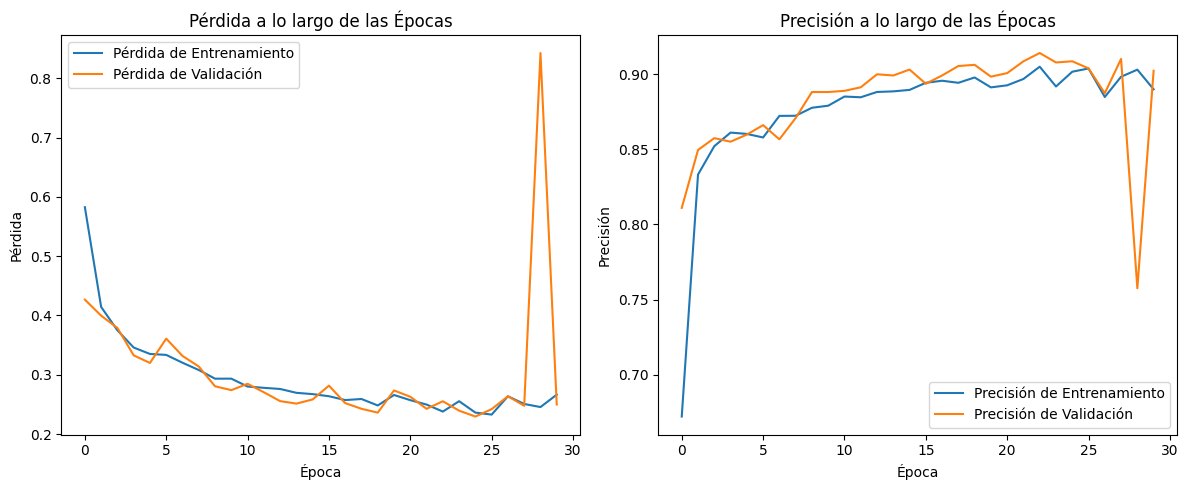

In [ ]:
# --- 6. EVALUACIÓN FINAL Y VISUALIZACIÓN ---

print("\n--- Evaluando en el conjunto de prueba ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy().flatten())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy en prueba: {accuracy:.4f}")
print(f"Precision en prueba: {precision:.4f}")
print(f"Recall en prueba: {recall:.4f}")
print(f"F1-Score en prueba: {f1:.4f}")

# Graficar resultados del entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Precisión de Entrenamiento')
plt.plot(history['val_acc'], label='Precisión de Validación')
plt.title('Precisión a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

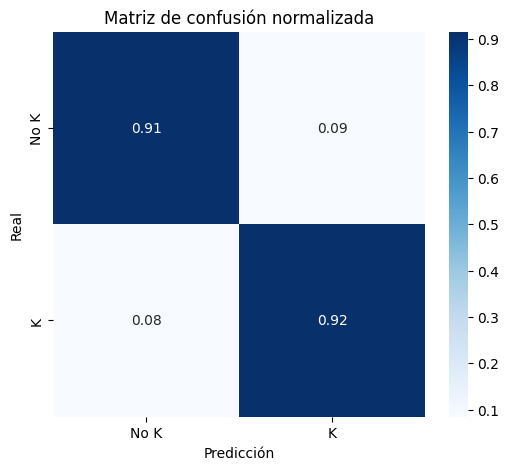

In [ ]:
def plot_confusion_matrix(model, dataloader, device, title="Matriz de confusión normalizada"):
    """
    Evalúa el modelo en el dataloader y grafica la matriz de confusión binaria normalizada.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # --- CAMBIO 1: Normalizar la matriz por las filas (clases reales) ---
    cm = confusion_matrix(all_labels, all_preds, normalize='true')

    # Graficar
    plt.figure(figsize=(6, 5))
    # --- CAMBIO 2: Cambiar el formato para mostrar decimales ---
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No K", "K"], yticklabels=["No K", "K"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

# Ejemplo de uso
plot_confusion_matrix(model, test_loader, device)


### 5 Entrenamientos

In [ ]:
# --- 5. CICLO PRINCIPAL PARA MÚLTIPLES ENTRENAMIENTOS ---

NUM_RUNS = 5  # Número de veces que quieres entrenar el modelo
all_histories = [] # Lista para guardar los resultados de cada entrenamiento

for i in range(NUM_RUNS):
    print(f"\\n--- Iniciando Corrida de Entrenamiento {i+1}/{NUM_RUNS} ---\\n")

    # --- Hiperparámetros ---
    EPOCHS = 40 # Usaré 40 como en tu gráfico de ejemplo
    LEARNING_RATE = 0.0001
    patience = 10
    patience_counter = 0
    best_val_loss = float('inf')

    # --- ¡Importante! Reiniciar el modelo y el optimizador en cada corrida ---
    model = CNNDETECTAR().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Almacenar historial para la corrida actual
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # --- Bucle de entrenamiento para una corrida ---
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Corrida {i+1}, Época {epoch+1}/{EPOCHS} | "
              f"Loss ent: {train_loss:.4f} | Acc ent: {train_acc:.4f} | "
              f"Loss val: {val_loss:.4f} | Acc val: {val_acc:.4f}")

        # Lógica de Early Stopping (opcional, pero buena práctica)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"--- Early stopping en la época {epoch+1} ---")
            break

    # Guardar el historial de esta corrida en la lista principal
    all_histories.append(history)

print("\\n--- Todas las corridas de entrenamiento han finalizado ---")

\n--- Iniciando Corrida de Entrenamiento 1/5 ---\n
Corrida 1, Época 1/40 | Loss ent: 0.5784 | Acc ent: 0.6892 | Loss val: 0.4230 | Acc val: 0.8118
Corrida 1, Época 2/40 | Loss ent: 0.4115 | Acc ent: 0.8389 | Loss val: 0.3750 | Acc val: 0.8669
Corrida 1, Época 3/40 | Loss ent: 0.3582 | Acc ent: 0.8557 | Loss val: 0.3258 | Acc val: 0.8591
Corrida 1, Época 4/40 | Loss ent: 0.3512 | Acc ent: 0.8572 | Loss val: 0.3104 | Acc val: 0.8701
Corrida 1, Época 5/40 | Loss ent: 0.3224 | Acc ent: 0.8699 | Loss val: 0.3577 | Acc val: 0.8764
Corrida 1, Época 6/40 | Loss ent: 0.3193 | Acc ent: 0.8703 | Loss val: 0.2859 | Acc val: 0.8835
Corrida 1, Época 7/40 | Loss ent: 0.2981 | Acc ent: 0.8783 | Loss val: 0.2751 | Acc val: 0.8890
Corrida 1, Época 8/40 | Loss ent: 0.2921 | Acc ent: 0.8798 | Loss val: 0.2786 | Acc val: 0.8921
Corrida 1, Época 9/40 | Loss ent: 0.2879 | Acc ent: 0.8811 | Loss val: 0.3390 | Acc val: 0.8496
Corrida 1, Época 10/40 | Loss ent: 0.2943 | Acc ent: 0.8824 | Loss val: 0.2828 | Acc 

<Figure size 1500x600 with 0 Axes>

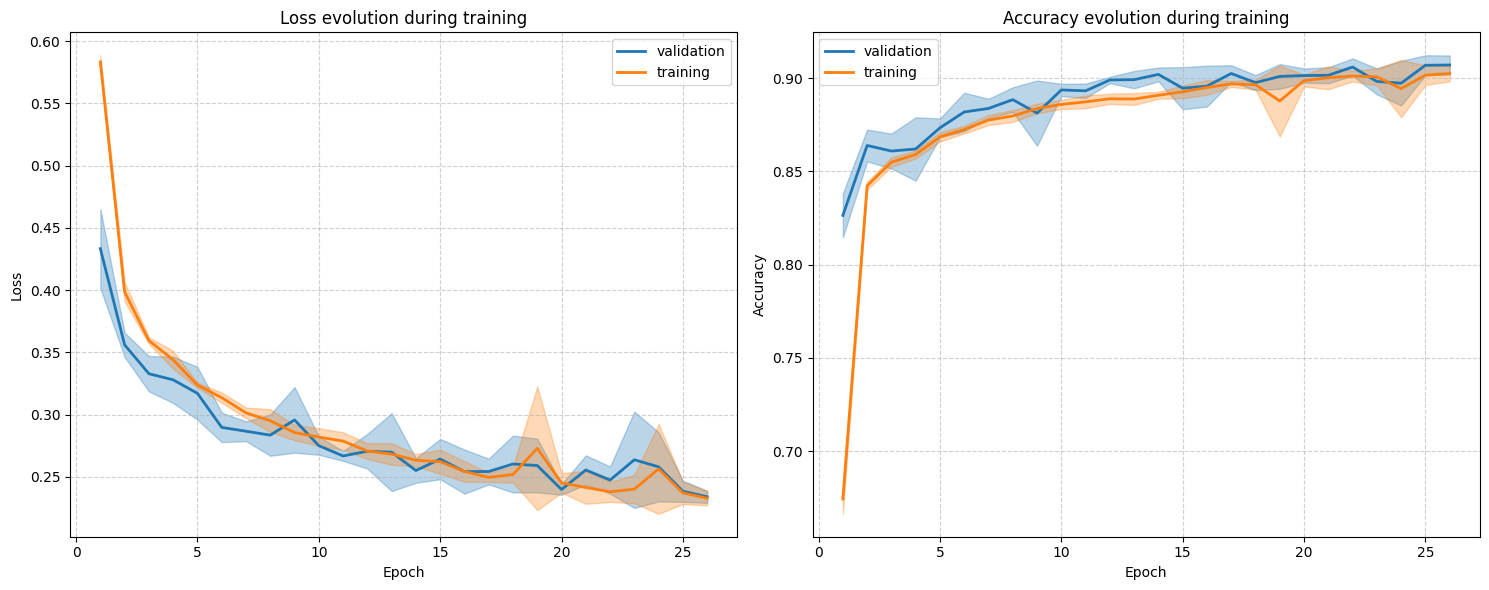

In [ ]:
# --- NUEVO CÓDIGO PARA MANEJAR LONGITUDES DIFERENTES ---
# 1. Encontrar la longitud de la corrida más corta debido al early stopping
min_epochs = min([len(h['train_loss']) for h in all_histories])

# 2. Truncar todas las listas de historial a esa longitud mínima
train_loss_all = np.array([h['train_loss'][:min_epochs] for h in all_histories])
val_loss_all = np.array([h['val_loss'][:min_epochs] for h in all_histories])
train_acc_all = np.array([h['train_acc'][:min_epochs] for h in all_histories])
val_acc_all = np.array([h['val_acc'][:min_epochs] for h in all_histories])
# --- FIN DE LA CORRECCIÓN ---

# Calcular promedio (mean) y desviación estándar (std) a lo largo de las corridas (axis=0)
mean_train_loss = np.mean(train_loss_all, axis=0)
std_train_loss = np.std(train_loss_all, axis=0)

mean_val_loss = np.mean(val_loss_all, axis=0)
std_val_loss = np.std(val_loss_all, axis=0)

mean_train_acc = np.mean(train_acc_all, axis=0)
std_train_acc = np.std(train_acc_all, axis=0)

mean_val_acc = np.mean(val_acc_all, axis=0)
std_val_acc = np.std(val_acc_all, axis=0)

# El resto de tu código de graficación funcionará perfectamente con esto.
# Eje X para los gráficos (número de épocas)
epochs_range = range(1, len(mean_train_loss) + 1)

# --- Graficar resultados ---
plt.figure(figsize=(15, 6))

# (El resto de tu código para plt.plot y plt.fill_between va aquí y no necesita cambios)

# --- Graficar resultados ---
plt.figure(figsize=(15, 6))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
# Curva de validación
plt.plot(epochs_range, mean_val_loss, label='validation', color='tab:blue', lw=2)
plt.fill_between(epochs_range, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='tab:blue', alpha=0.3)
# Curva de entrenamiento
plt.plot(epochs_range, mean_train_loss, label='training', color='tab:orange', lw=2)
plt.fill_between(epochs_range, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='tab:orange', alpha=0.3)
plt.title('Loss evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
# Curva de validación
plt.plot(epochs_range, mean_val_acc, label='validation', color='tab:blue', lw=2)
plt.fill_between(epochs_range, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='tab:blue', alpha=0.3)
# Curva de entrenamiento
plt.plot(epochs_range, mean_train_acc, label='training', color='tab:orange', lw=2)
plt.fill_between(epochs_range, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='tab:orange', alpha=0.3)
plt.title('Accuracy evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

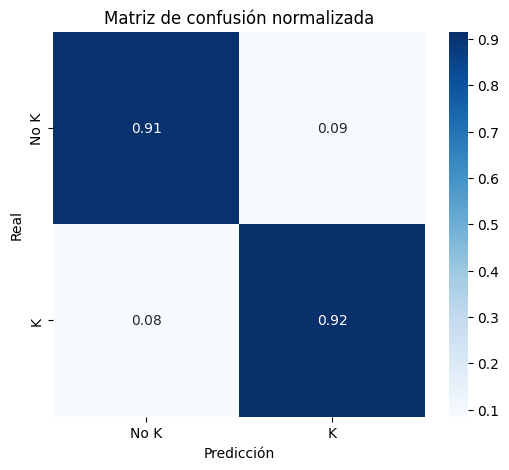

In [ ]:
def plot_confusion_matrix(model, dataloader, device, title="Matriz de confusión normalizada"):
    """
    Evalúa el modelo en el dataloader y grafica la matriz de confusión binaria normalizada.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # --- CAMBIO 1: Normalizar la matriz por las filas (clases reales) ---
    cm = confusion_matrix(all_labels, all_preds, normalize='true')

    # Graficar
    plt.figure(figsize=(6, 5))
    # --- CAMBIO 2: Cambiar el formato para mostrar decimales ---
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No K", "K"], yticklabels=["No K", "K"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

# Ejemplo de uso
plot_confusion_matrix(model, test_loader, device)

### Probando con MLP

In [ ]:
class CNNDETECTAR_MLP(nn.Module):
    """
    Modelo CRNN con un clasificador MLP final para la tarea de detección.
    """
    def __init__(self, in_channels=1, Nf=32, N1=128, N2=128, p1=0.5, p2=0.5):
        super(CNNDETECTAR_MLP, self).__init__()

        # --- Extractor de Características Convolucional (Sin cambios) ---
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=Nf, out_channels=Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=Nf, out_channels=2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=2*Nf, out_channels=2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(in_channels=2*Nf, out_channels=4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=4*Nf, out_channels=4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # --- Capas de Dropout (Sin cambios) ---
        self.dropout1 = nn.Dropout(p=p1)
        self.dropout2 = nn.Dropout(p=p2)

        # --- Bloques Recurrentes (Bi-LSTM, Sin cambios) ---
        self.blstm1 = nn.LSTM(input_size=4*Nf, hidden_size=N1, batch_first=True, bidirectional=True)
        self.blstm2 = nn.LSTM(input_size=2*N1, hidden_size=N1, batch_first=True, bidirectional=True)

        # --- CAMBIO 1: Reemplazar el clasificador CNN con un MLP ---
        # El MLP operará sobre las características de cada paso de tiempo (2*N1 de la Bi-LSTM).
        self.classifier_mlp = nn.Sequential(
            nn.Linear(in_features=2*N1, out_features=N2),
            nn.ReLU(),
            nn.Linear(in_features=N2, out_features=1) # Salida de 1 para clasificación binaria
        )

    def forward(self, x):
        """
        Define el forward pass con el nuevo clasificador MLP.
        """
        # Bloques convolucionales (Sin cambios)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Reshape para LSTMs (Sin cambios)
        x = x.permute(0, 2, 1) # Shape -> (batch_size, 500, features)

        # Bloques recurrentes (Sin cambios)
        x = self.dropout1(x)
        x, _ = self.blstm1(x)
        x = self.dropout2(x)
        x, _ = self.blstm2(x)
        x = self.dropout2(x)
        # Shape de salida de la LSTM -> (batch_size, 500, 2*N1)

        # --- CAMBIO 2: Pasar a través del MLP y promediar ---
        # Ya no necesitamos permutar las dimensiones para la CNN.
        # Pasamos la salida de la LSTM directamente al MLP.
        logits_seq = self.classifier_mlp(x) # Shape -> (batch_size, 500, 1)

        # El Global Average Pooling sigue siendo necesario para obtener una predicción por señal.
        # Promediamos a lo largo de la dimensión de la secuencia (dim=1).
        logits = torch.mean(logits_seq, dim=1) # Shape -> (batch_size, 1)

        return logits

In [ ]:
# --- 5. CICLO PRINCIPAL DE ENTRENAMIENTO (CON EARLY STOPPING) ---

# Haz esto una vez antes de tu bucle de entrenamiento
# Concatena todas las etiquetas para calcular la proporción
all_labels_tensor = torch.cat([labels for _, labels in train_loader], dim=0)

# Calcula cuántos puntos son "No K" (0) y cuántos son "K" (1)
neg_count = (all_labels_tensor == 0).sum()
pos_count = (all_labels_tensor == 1).sum()

# El peso es la relación entre negativos y positivos
pos_weight = neg_count / pos_count

print(f"Peso positivo calculado: {pos_weight:.2f}")

# Hiperparámetros
EPOCHS = 30
LEARNING_RATE = 0.0001

# --- Early Stopping Parameters ---
patience = 10  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize with a very high value

# Instanciar modelo, función de pérdida y optimizador
model = CNNDETECTAR_MLP().to(device)
# Luego, en tu celda de entrenamiento, instancia el criterio con este peso
# Asegúrate de que el peso sea un tensor y esté en el dispositivo correcto (GPU/CPU)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Almacenar historial para graficar
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}


print("\n--- Iniciando Entrenamiento ---")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Época {epoch+1}/{EPOCHS} | "
          f"Loss de entrenamiento: {train_loss:.4f} | Acc de entrenamiento: {train_acc:.4f} | "
          f"Loss de validación: {val_loss:.4f} | Acc de validación: {val_acc:.4f}")

    # --- Early Stopping Logic ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Optional: Save the best model here
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\n--- Early stopping en la época {epoch+1} ---")
        break # Exit the training loop

print("--- Entrenamiento Finalizado ---")

Peso positivo calculado: 0.99

--- Iniciando Entrenamiento ---
Época 1/30 | Loss de entrenamiento: 0.6075 | Acc de entrenamiento: 0.6512 | Loss de validación: 0.8211 | Acc de validación: 0.4984
Época 2/30 | Loss de entrenamiento: 0.5543 | Acc de entrenamiento: 0.7712 | Loss de validación: 0.4186 | Acc de validación: 0.8268
Época 3/30 | Loss de entrenamiento: 0.4170 | Acc de entrenamiento: 0.8291 | Loss de validación: 0.3777 | Acc de validación: 0.8362
Época 4/30 | Loss de entrenamiento: 0.3746 | Acc de entrenamiento: 0.8532 | Loss de validación: 0.3642 | Acc de validación: 0.8575
Época 5/30 | Loss de entrenamiento: 0.3526 | Acc de entrenamiento: 0.8597 | Loss de validación: 0.3605 | Acc de validación: 0.8622
Época 6/30 | Loss de entrenamiento: 0.3428 | Acc de entrenamiento: 0.8632 | Loss de validación: 0.3325 | Acc de validación: 0.8583
Época 7/30 | Loss de entrenamiento: 0.3376 | Acc de entrenamiento: 0.8707 | Loss de validación: 0.3016 | Acc de validación: 0.8843
Época 8/30 | Loss de


--- Evaluando en el conjunto de prueba ---
Accuracy en prueba: 0.9001
Precision en prueba: 0.8961
Recall en prueba: 0.9060
F1-Score en prueba: 0.9010


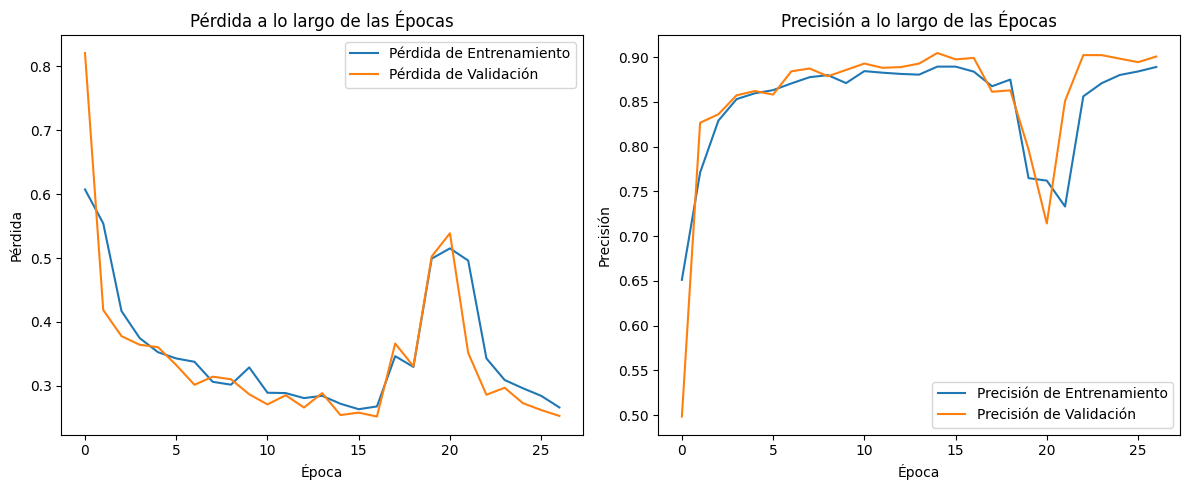

In [ ]:
# --- 6. EVALUACIÓN FINAL Y VISUALIZACIÓN ---

print("\n--- Evaluando en el conjunto de prueba ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy().flatten())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy en prueba: {accuracy:.4f}")
print(f"Precision en prueba: {precision:.4f}")
print(f"Recall en prueba: {recall:.4f}")
print(f"F1-Score en prueba: {f1:.4f}")

# Graficar resultados del entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Precisión de Entrenamiento')
plt.plot(history['val_acc'], label='Precisión de Validación')
plt.title('Precisión a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

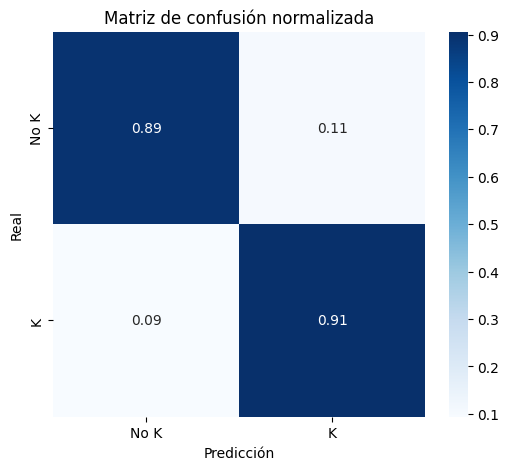

In [ ]:
def plot_confusion_matrix(model, dataloader, device, title="Matriz de confusión normalizada"):
    """
    Evalúa el modelo en el dataloader y grafica la matriz de confusión binaria normalizada.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # --- CAMBIO 1: Normalizar la matriz por las filas (clases reales) ---
    cm = confusion_matrix(all_labels, all_preds, normalize='true')

    # Graficar
    plt.figure(figsize=(6, 5))
    # --- CAMBIO 2: Cambiar el formato para mostrar decimales ---
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No K", "K"], yticklabels=["No K", "K"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

# Ejemplo de uso
plot_confusion_matrix(model, test_loader, device)

##### 5 Entrenamientos MLP

In [ ]:
# --- 5. CICLO PRINCIPAL PARA MÚLTIPLES ENTRENAMIENTOS ---

NUM_RUNS = 5  # Número de veces que quieres entrenar el modelo
all_histories = [] # Lista para guardar los resultados de cada entrenamiento

for i in range(NUM_RUNS):
    print(f"\\n--- Iniciando Corrida de Entrenamiento {i+1}/{NUM_RUNS} ---\\n")

    # --- Hiperparámetros ---
    EPOCHS = 40 # Usaré 40 como en tu gráfico de ejemplo
    LEARNING_RATE = 0.0001
    patience = 10
    patience_counter = 0
    best_val_loss = float('inf')

    # --- ¡Importante! Reiniciar el modelo y el optimizador en cada corrida ---
    model = CNNDETECTAR_MLP().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Almacenar historial para la corrida actual
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # --- Bucle de entrenamiento para una corrida ---
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Corrida {i+1}, Época {epoch+1}/{EPOCHS} | "
              f"Loss ent: {train_loss:.4f} | Acc ent: {train_acc:.4f} | "
              f"Loss val: {val_loss:.4f} | Acc val: {val_acc:.4f}")

        # Lógica de Early Stopping (opcional, pero buena práctica)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"--- Early stopping en la época {epoch+1} ---")
            break

    # Guardar el historial de esta corrida en la lista principal
    all_histories.append(history)

print("\\n--- Todas las corridas de entrenamiento han finalizado ---")

\n--- Iniciando Corrida de Entrenamiento 1/5 ---\n
Corrida 1, Época 1/40 | Loss ent: 0.5615 | Acc ent: 0.6954 | Loss val: 0.4982 | Acc val: 0.8260
Corrida 1, Época 2/40 | Loss ent: 0.4171 | Acc ent: 0.8227 | Loss val: 0.3551 | Acc val: 0.8543
Corrida 1, Época 3/40 | Loss ent: 0.3687 | Acc ent: 0.8548 | Loss val: 0.3525 | Acc val: 0.8583
Corrida 1, Época 4/40 | Loss ent: 0.3559 | Acc ent: 0.8555 | Loss val: 0.3193 | Acc val: 0.8740
Corrida 1, Época 5/40 | Loss ent: 0.3270 | Acc ent: 0.8688 | Loss val: 0.3134 | Acc val: 0.8740
Corrida 1, Época 6/40 | Loss ent: 0.3149 | Acc ent: 0.8720 | Loss val: 0.3448 | Acc val: 0.8677
Corrida 1, Época 7/40 | Loss ent: 0.3046 | Acc ent: 0.8792 | Loss val: 0.3218 | Acc val: 0.8756
Corrida 1, Época 8/40 | Loss ent: 0.2939 | Acc ent: 0.8790 | Loss val: 0.3215 | Acc val: 0.8630
Corrida 1, Época 9/40 | Loss ent: 0.2859 | Acc ent: 0.8846 | Loss val: 0.2913 | Acc val: 0.8890
Corrida 1, Época 10/40 | Loss ent: 0.2853 | Acc ent: 0.8796 | Loss val: 0.3823 | Acc 

<Figure size 1500x600 with 0 Axes>

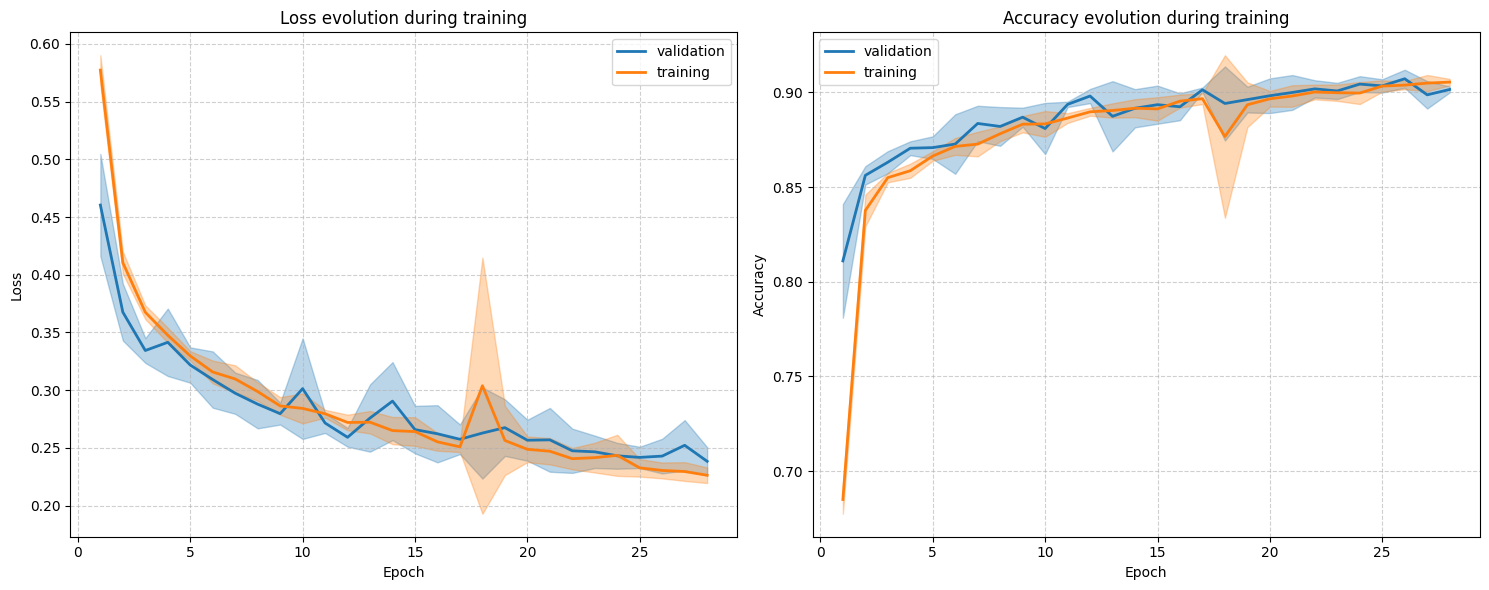

In [ ]:
# --- NUEVO CÓDIGO PARA MANEJAR LONGITUDES DIFERENTES ---
# 1. Encontrar la longitud de la corrida más corta debido al early stopping
min_epochs = min([len(h['train_loss']) for h in all_histories])

# 2. Truncar todas las listas de historial a esa longitud mínima
train_loss_all = np.array([h['train_loss'][:min_epochs] for h in all_histories])
val_loss_all = np.array([h['val_loss'][:min_epochs] for h in all_histories])
train_acc_all = np.array([h['train_acc'][:min_epochs] for h in all_histories])
val_acc_all = np.array([h['val_acc'][:min_epochs] for h in all_histories])
# --- FIN DE LA CORRECCIÓN ---

# Calcular promedio (mean) y desviación estándar (std) a lo largo de las corridas (axis=0)
mean_train_loss = np.mean(train_loss_all, axis=0)
std_train_loss = np.std(train_loss_all, axis=0)

mean_val_loss = np.mean(val_loss_all, axis=0)
std_val_loss = np.std(val_loss_all, axis=0)

mean_train_acc = np.mean(train_acc_all, axis=0)
std_train_acc = np.std(train_acc_all, axis=0)

mean_val_acc = np.mean(val_acc_all, axis=0)
std_val_acc = np.std(val_acc_all, axis=0)

# El resto de tu código de graficación funcionará perfectamente con esto.
# Eje X para los gráficos (número de épocas)
epochs_range = range(1, len(mean_train_loss) + 1)

# --- Graficar resultados ---
plt.figure(figsize=(15, 6))

# (El resto de tu código para plt.plot y plt.fill_between va aquí y no necesita cambios)

# --- Graficar resultados ---
plt.figure(figsize=(15, 6))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
# Curva de validación
plt.plot(epochs_range, mean_val_loss, label='validation', color='tab:blue', lw=2)
plt.fill_between(epochs_range, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='tab:blue', alpha=0.3)
# Curva de entrenamiento
plt.plot(epochs_range, mean_train_loss, label='training', color='tab:orange', lw=2)
plt.fill_between(epochs_range, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='tab:orange', alpha=0.3)
plt.title('Loss evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
# Curva de validación
plt.plot(epochs_range, mean_val_acc, label='validation', color='tab:blue', lw=2)
plt.fill_between(epochs_range, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='tab:blue', alpha=0.3)
# Curva de entrenamiento
plt.plot(epochs_range, mean_train_acc, label='training', color='tab:orange', lw=2)
plt.fill_between(epochs_range, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='tab:orange', alpha=0.3)
plt.title('Accuracy evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy en prueba: {accuracy:.4f}")
print(f"Precision en prueba: {precision:.4f}")
print(f"Recall en prueba: {recall:.4f}")
print(f"F1-Score en prueba: {f1:.4f}")

Accuracy en prueba: 0.9001
Precision en prueba: 0.8961
Recall en prueba: 0.9060
F1-Score en prueba: 0.9010


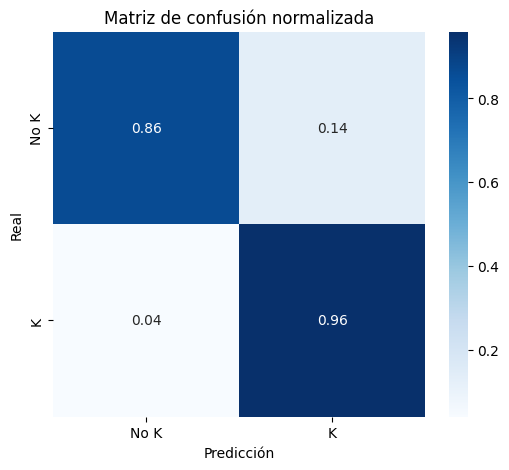

In [ ]:
def plot_confusion_matrix(model, dataloader, device, title="Matriz de confusión normalizada"):
    """
    Evalúa el modelo en el dataloader y grafica la matriz de confusión binaria normalizada.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # --- CAMBIO 1: Normalizar la matriz por las filas (clases reales) ---
    cm = confusion_matrix(all_labels, all_preds, normalize='true')

    # Graficar
    plt.figure(figsize=(6, 5))
    # --- CAMBIO 2: Cambiar el formato para mostrar decimales ---
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No K", "K"], yticklabels=["No K", "K"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

# Ejemplo de uso
plot_confusion_matrix(model, test_loader, device)


# Detectar y Localizar

In [ ]:
# ahora el de (1,4000) -> (1,4000)


class CRNN_DETECTAR_LOCALIZAR(nn.Module):
    """
    Implementación del modelo CRNN descrito en el diagrama y la tabla de hiperparámetros.
    """
    def __init__(self, in_channels=1, num_classes=2, Nf=64, N1=256, N2=128, p1=0.2, p2=0.5):
        super(CRNN_DETECTAR_LOCALIZAR, self).__init__()

        # --- Bloque Convolucional (Encoder) ---
        # Sigue el patrón: Conv -> Conv -> Pool
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(Nf, Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2) # T -> T/2
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(Nf, 2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(2*Nf, 2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2) # T/2 -> T/4
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(2*Nf, 4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(4*Nf, 4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2) # T/4 -> T/8
        )

        # --- Bloque Recurrente ---
        self.dropout1 = nn.Dropout(p=p1)
        # La entrada al LSTM es el número de canales de salida del último bloque conv (4*Nf)
        self.blstm1 = nn.LSTM(input_size=4*Nf, hidden_size=N1, num_layers=1, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(p=p2)
        # La entrada al segundo LSTM es la salida del primero (2*N1 porque es bidireccional)
        self.blstm2 = nn.LSTM(input_size=2*N1, hidden_size=N1, num_layers=1, batch_first=True, bidirectional=True)

        # --- Clasificador Final ---
        # Usa convoluciones 1x1 para clasificar cada punto de la secuencia T/8
        self.classifier = nn.Sequential(
            nn.Conv1d(2*N1, N2, kernel_size=1), # Salida del LSTM (2*N1) a N2
            nn.ReLU(),
            nn.Conv1d(N2, num_classes, kernel_size=1) # De N2 al número de clases (2 según el diagrama)
        )

    def forward(self, x):
        # x shape: (batch, channels, T) -> ej: (32, 1, 4000)

        # Encoder
        x = self.conv_block1(x) # -> (32, Nf, T/2)
        x = self.conv_block2(x) # -> (32, 2*Nf, T/4)
        x = self.conv_block3(x) # -> (32, 4*Nf, T/8), ej: (32, 256, 500)

        # Preparación para LSTMs
        # (batch, channels, seq_len) -> (batch, seq_len, channels)
        x = x.permute(0, 2, 1) # -> (32, 500, 256)

        # Bloque Recurrente
        x = self.dropout1(x)
        x, _ = self.blstm1(x)
        x = self.dropout2(x)
        x, _ = self.blstm2(x)

        # Preparación para el clasificador
        # (batch, seq_len, channels) -> (batch, channels, seq_len)
        x = x.permute(0, 2, 1) # -> (32, 2*N1, 500), ej: (32, 512, 500)

        # Clasificador
        logits = self.classifier(x) # -> (32, num_classes, 500)

        return logits

In [ ]:
# df_detectar solo debe tener las columnas signal y existeK
df_detectar = df[['signal', 'labels']]

# División de datos: 80% entrenamiento, 10% validación, 10% prueba
# Primero, separamos el conjunto de entrenamiento del resto
train_df, temp_df = train_test_split(
    df_detectar, test_size=0.2, random_state=42
)
# Luego, dividimos el resto en validación y prueba
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42
)

print(f"\nTamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(val_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")



Tamaño del conjunto de entrenamiento: 10164
Tamaño del conjunto de validación: 1270
Tamaño del conjunto de prueba: 1271


In [ ]:
# This class is now set up for localization.
class SignalDataset(Dataset):
    """Custom Dataset for loading signals and localization labels."""
    def __init__(self, dataframe):
        self.signals = torch.tensor(np.array(dataframe['signal'].tolist()), dtype=torch.float32)
        # CHANGED: Switched from 'existeK' to 'labels'.
        # Assumes 'labels' column contains lists/arrays of the same length as the signal.
        self.labels = torch.tensor(np.array(dataframe['labels'].tolist()), dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Add a "channel" dimension for the CNN, e.g., (4000) -> (1, 4000)
        signal = self.signals[idx].unsqueeze(0)
        # The label is now a vector, so we also add a channel dim, e.g., (4000) -> (1, 4000)
        label = self.labels[idx].unsqueeze(0)
        return signal, label

BATCH_SIZE = 64

# Crear instancias de Dataset
train_dataset = SignalDataset(train_df)
val_dataset = SignalDataset(val_df)
test_dataset = SignalDataset(test_df)

# Crear instancias de DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



# --- 4. UPDATED TRAINING AND EVALUATION FUNCTIONS ---

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Function to train the model for one epoch (for localization)."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0 # This will now count total points, not signals

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # The model output must have the same shape as the labels, e.g., (batch, 1, 4000)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Predictions are made for every point in the signal
        preds = (torch.sigmoid(outputs) > 0.5).float()
        # This correctly counts all matching points across the batch
        correct_predictions += (preds == labels).sum().item()
        # CHANGED: We now count every single point in the batch for accuracy calculation.
        total_samples += labels.numel()

    epoch_loss = running_loss / len(dataloader.dataset) # Loss is still per-signal
    epoch_acc = correct_predictions / total_samples      # Accuracy is now per-point
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Function to evaluate the model on a dataset (for localization)."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0 # This will now count total points, not signals

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            # CHANGED: We now count every single point in the batch for accuracy calculation.
            total_samples += labels.numel()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [ ]:
# --- 5. CICLO PRINCIPAL DE ENTRENAMIENTO (CON EARLY STOPPING) ---

# Hiperparámetros
EPOCHS = 30
LEARNING_RATE = 0.0001

# --- Early Stopping Parameters ---
patience = 10  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize with a very high value

# Instanciar modelo, función de pérdida y optimizador
model_crnn = CRNN_DETECTAR_LOCALIZAR(
    in_channels=1,
    num_classes=2, # El diagrama termina con 2 clases
    Nf=64,
    N1=256,
    N2=128,
    p1=0.2,
    p2=0.5
).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Almacenar historial para graficar
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("\n--- Iniciando Entrenamiento ---")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Época {epoch+1}/{EPOCHS} | "
          f"Loss de entrenamiento: {train_loss:.4f} | Acc de entrenamiento: {train_acc:.4f} | "
          f"Loss de validación: {val_loss:.4f} | Acc de validación: {val_acc:.4f}")

    # --- Early Stopping Logic ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Optional: Save the best model here
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\n--- Early stopping en la época {epoch+1} ---")
        break # Exit the training loop

print("--- Entrenamiento Finalizado ---")


--- Iniciando Entrenamiento ---


ValueError: Target size (torch.Size([64, 1, 4000])) must be the same as input size (torch.Size([64, 1]))

In [ ]:
# --- 6. EVALUACIÓN FINAL Y VISUALIZACIÓN ---

print("\n--- Evaluando en el conjunto de prueba ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy().flatten())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy en prueba: {accuracy:.4f}")
print(f"Precision en prueba: {precision:.4f}")
print(f"Recall en prueba: {recall:.4f}")
print(f"F1-Score en prueba: {f1:.4f}")

# Graficar resultados del entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Precisión de Entrenamiento')
plt.plot(history['val_acc'], label='Precisión de Validación')
plt.title('Precisión a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()